In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

# Get the planet dataset from Kaggle (need to configure Kaggle credential json file first

In [3]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/planet')

In [4]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  

100%|███████████████████████████████████████▊| 598M/600M [00:22<00:00, 28.5MB/s]
100%|████████████████████████████████████████| 600M/600M [00:22<00:00, 27.5MB/s]


In [5]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

100%|█████████████████████████████████████████| 159k/159k [00:00<00:00, 822kB/s]



In [6]:
# ! conda install -y -c haasad eidl7zip

Solving environment: done

## Package Plan ##

  environment location: /home/ubuntu/anaconda3/envs/python37

  added / updated specs: 
    - eidl7zip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    eidl7zip-1.0.0             |                1         565 KB  haasad

The following NEW packages will be INSTALLED:

    eidl7zip: 1.0.0-1 haasad


eidl7zip-1.0.0       | 565 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [7]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

Multiclass csv file

In [8]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
(path/'train-jpg').ls()[:10]

[PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_4005.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_39161.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_19334.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_27345.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_6017.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_20705.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_36201.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_19125.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_23232.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet/train-jpg/train_37336.jpg')]

# Create databunch

In [13]:
tfms = get_transforms(flip_vert=True, # also flip vertically
                      max_lighting=0.1, 
                      max_zoom=1.05, 
                      max_warp=0.) # no warp

In [ ]:
# # factory method for databunch
# data = ImageDataBunch.from_csv(planet, folder='train', 
#                                size=128, 
#                                suffix='.jpg', 
#                                sep = ' ', 
#                                ds_tfms=tfms)

In [19]:
# using new databunch api
np.random.seed(1204)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2) # since there is no valid folder, random split
       .label_from_df(sep=' '))


In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

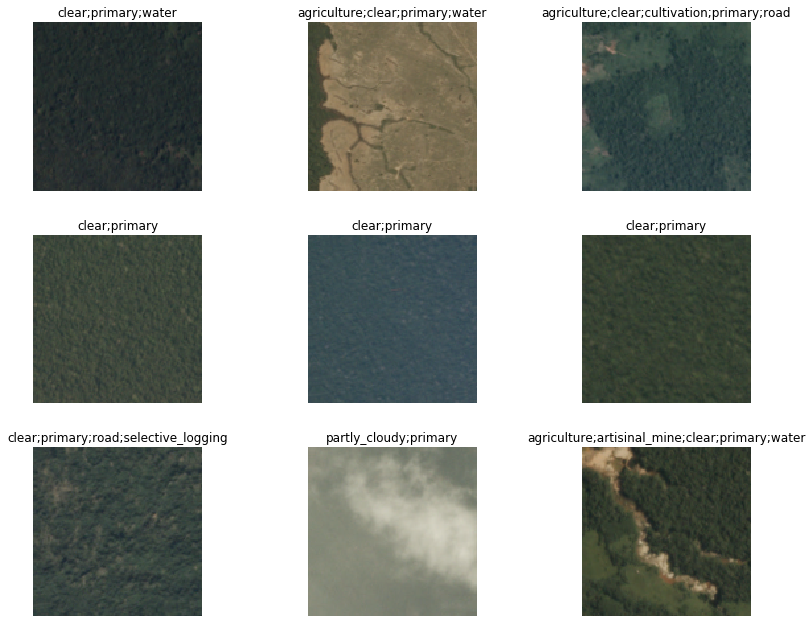

In [20]:
data.show_batch(rows=3, figsize=(12,9))

# How data holds multi-label dataset

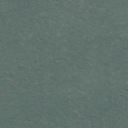

In [27]:
data.train_ds[0][0]

In [28]:
data.train_ds[0][1]

MultiCategory haze;primary

In [30]:
data.train_ds[0][1][0],data.train_ds[0][1][1]

(Category haze, Category primary)

In [32]:
data.classes

['haze',
 'primary',
 'clear',
 'agriculture',
 'habitation',
 'road',
 'water',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [33]:
data.c

17

# resnet model

In [34]:
arch = models.resnet50

In [35]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 44621239.88it/s]


In [38]:
learn.layer_groups[-1]

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): AdaptiveMaxPool2d(output_size=1)
  (2): Lambda()
  (3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.25)
  (5): Linear(in_features=4096, out_features=512, bias=True)
  (6): ReLU(inplace)
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.5)
  (9): Linear(in_features=512, out_features=17, bias=True)
)

In [39]:
learn.loss_func
# binary cross entropy with logits

<function torch.nn.functional.binary_cross_entropy_with_logits(input, target, weight=None, size_average=None, reduce=None, reduction='elementwise_mean', pos_weight=None)>

## Note:  How BCE with logits is calculated in pytorch

In [57]:
# example of BCE with logits
inp_temp = torch.randn((2,3), requires_grad=True)
y_temp= torch.empty((2,3)).random_(2)
loss_temp = F.binary_cross_entropy_with_logits(inp_temp, y_temp)
loss_temp.backward()

In [58]:
inp_temp

tensor([[ 0.9039,  0.3314,  0.4364],
        [-0.2509,  0.4365, -0.5117]], requires_grad=True)

In [59]:
y_temp

tensor([[0., 0., 1.],
        [1., 0., 1.]])

In [60]:
loss_temp

tensor(0.8930, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

**BCE Entropy with logits with reduction='elementwise_mean'**: raw output (inp_temp) -> sigmoid -> binary cross entropy for each entry in row -> mean for each row -> mean for all row 

In [61]:
def sigmoid_func(a):
    return 1/(1+np.exp(-a))
inp_temp_sig = sigmoid_func(to_np(inp_temp))

In [62]:
inp_temp_sig

array([[0.711746, 0.58209 , 0.607407],
       [0.437601, 0.607435, 0.374792]], dtype=float32)

In [63]:
def binary_nll(y_prob,y):
    return -(y*np.log(y_prob) + (1-y)*np.log(1-y_prob))

In [64]:
y_temp = to_np(y_temp)

In [66]:
b_CE = [binary_nll(y_prob,y) for y_prob,y in zip(inp_temp_sig[0],y_temp[0])]
b_CE_row1=np.mean(b_CE)
b_CE_row1

0.8716528484388618

In [67]:
b_CE = [binary_nll(y_prob,y) for y_prob,y in zip(inp_temp_sig[1],y_temp[1])]
b_CE_row2=np.mean(b_CE)
b_CE_row2

0.9142948875329616

In [68]:
np.mean([b_CE_row1,b_CE_row2])

0.8929738679859117

In [69]:
# same (after round up)
loss_temp

tensor(0.8930, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

# Continue resnet

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


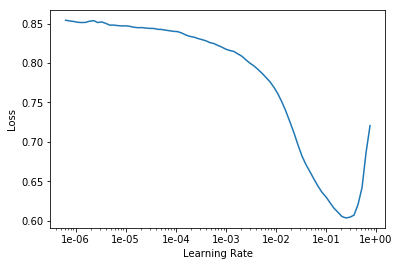

In [54]:
learn.recorder.plot()

In [70]:
lr = 1e-2 # lowest loss at 5e-01 -> 5e-01/10 ?

In [72]:
slice(lr)

slice(None, 0.01, None)

In [73]:
learn.fit_one_cycle(5, max_lr=slice(lr))

Total time: 16:10
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.115583    0.102590    0.951626         0.907451  (03:16)
2      0.112181    0.100407    0.948690         0.915163  (03:13)
3      0.101689    0.091742    0.956538         0.920041  (03:13)
4      0.093357    0.085037    0.958565         0.926469  (03:13)
5      0.088106    0.082835    0.957854         0.927894  (03:13)



In [74]:
# learn.save('stage-1-5epochs-rn50')

In [ ]:
# unfreeze, lr find and train

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(5, slice(? lr/5))

In [ ]:
# learn.save('stage-2-rn50')

# Resize dataset using databunch api

In [ ]:
#128 to 256
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [76]:
# freeze, train, save, unfreeze, train, save

[Reference notebook](http://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb)

In [78]:
1e-2

0.01

In [77]:
(1e-2)/2

0.005

In [79]:
5e-3

0.005

# Prediction on test set? TODO

In [ ]:
learn.data = (src.add_test_folder('test-jpg')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))